In [19]:
#import libraries and data
import psycopg2
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
#connect to database oppurtunity_youth and create cursor
DBNAME = "opportunity_youth"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

In [3]:
#create a list of the table names
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['pums_2017',
 'puma_names_2010',
 'wa_jobs_2017',
 'wa_geo_xwalk',
 'ct_puma_xwalk']

In [4]:
# Creating a filtered data fram for youth in South King County Washington
# Filter puma_names_2010 to King County in Washington
# Filter pums_2017 for ages between 16 and 25
# Join pums_2017 with filtered puma_names_2010
# SQL query with info for puma, person, age, education, and work
# Column info:
    # PUMA          Public use microdata area code
    # puma_name     County, city, location
    # SERIALNO      Housing unit/GQ person serial number
    # sporder       Which person in housing unit
    # agep          Age
    # sch           school enrollment (1 = has not attended in last 3 months)
    # schl          Education level
    # esr           Employment status

df_weight = pd.read_sql(""" SELECT puma, puma_name, serialno, sporder, agep, sch, schl, esr, pwgtp
                    FROM puma_names_2010 pn
                    JOIN pums_2017 pms
                    USING (puma)
                    WHERE state_name LIKE 'Washington%'
                    AND puma_name LIKE 'King%'
                     AND puma_name LIKE '%South%'
                    AND agep BETWEEN 15.9 AND 25.0
                    ;""", conn)

df_weight

,puma,puma_name,serialno,sporder,agep,sch,schl,esr,pwgtp
0,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2013000003218,01,21.0,3,19,1,14.0
1,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2013000003218,02,21.0,1,16,1,15.0
2,11612,"King County (Far Southwest)--Federal Way, Des ...",2013000007063,02,19.0,2,18,6,30.0
3,11613,King County (Southwest Central)--Kent City ...,2013000008046,02,17.0,2,13,6,36.0
4,11614,King County (Southwest)--Auburn City & Lakelan...,2013000011255,02,17.0,2,12,6,13.0
...,...,...,...,...,...,...,...,...,...
3177,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2017001491175,01,19.0,2,20,6,1.0
3178,11613,King County (Southwest Central)--Kent City ...,2017001530818,01,23.0,1,21,1,26.0
3179,11606,"King County (Northwest)--Shoreline, Kenmore & ...",2017001511157,01,18.0,2,18,6,1.0
3180,11613,King County (Southwest Central)--Kent City ...,2017001518359,01,18.0,1,11,6,20.0


In [5]:
#Function that expands the table from 2878 rows to 68347 using pwgtp to account for the weights
def duplicate_rows(df, countcol):
    for _, row in df.iterrows():
        for i in range(int(row[countcol])-1):
            # Append this row at the end of the DataFrame
            df = df.append(row)

    # Remove countcol (could do a drop too to do that...)
    notcountcols = [x for x in df.columns if x != countcol]
    df = df[notcountcols]
    # optional: sort it by index
    df.sort_index(inplace=True)
    return df

In [6]:
#**WARNING: THIS CELL MAY TAKE 15 MIN TO RUN**
#Runs the function that duplicates the table
df_dup = duplicate_rows(df_weight, 'pwgtp')
df_dup = df_dup.reset_index()

In [7]:
#Code to add Educational Groups
def school_range (schl):
    if int(schl) < 15: return "No diploma"
    elif int(schl) < 17: return "HS diploma or GED"
    elif int(schl) < 19: return "Some College, no degree"
    elif int(schl) < 25: return "Degree (Associate or higher)"
    else: return "Unknown"
df_dup["School_Level"]= df_dup.schl.apply(school_range)

In [8]:
#Code to add OY_Status
def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    elif (int(esr) == 1 or int(esr) == 2 or int(esr) == 4 or int(esr) == 5) and int(sch) <= 15: return "Working without Diploma"
    else: return "Not Opportunity Youth"
df_dup["OY_Status"] = df_dup.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [281]:
def Y_Status (esr, sch):
    if (int(esr) == 3 or int(esr) == 6) and int(sch) == 1: return "Opportunity Youth"
    else: return "Not Opportunity Youth"
df_dup["Is_OY"] = df_dup.apply(lambda x: Y_Status(x["esr"], x["sch"]), axis=1)

In [282]:
#Code that adds Age_Group and groups ages into bins
df_dup['Age_Group'] = pd.cut(x=df_dup['agep'], bins=[16, 18, 21, 24], labels=['16-18', '19-21', '21-24'])

In [283]:
#adds Total_Population column that takes the total population of each age group
df_dup["Total_Populations"]=df_dup.groupby("Age_Group")["Age_Group"].transform("count")
df_dup["OY_Status_Counts"]=df_dup.groupby("OY_Status")["OY_Status"].transform("count")

In [284]:
#Sets up a new dataframe to filter for Oppurtinuty Youth
df_chart = df_dup
df_chart['schl'] = df_chart['schl'].astype(float)
#
#Creates a dataframe of df_dup2 that is only Opportunity Youth
oy_chart = df_dup.loc[df_dup["Is_OY"] == "Opportunity Youth"]
#Creates a dataframe of df_dp2 that is everyone not an Opportunity You
noy_chart = df_dup.loc[df_dup["Is_OY"] == "Not Opportunity Youth"]

In [285]:
#function that adds percentage of total to column
def add_perc_to_column(df, column_n, total):
    df[column_n] = (round(df[column_n]/total*100)).astype(str) + "% : " + (df[column_n]).astype(str)

In [286]:
#Level of Education by Age
#Group by and count by age group and education level
oy_chart.sort_values(["School_Level"])
totals = oy_chart.groupby(["School_Level"])["Total_Populations"].count()
grouper = oy_chart.groupby(["Age_Group", "School_Level"], as_index=False).count()
total_pop = totals.sum()

In [287]:
#Creates School Level Pivot
#Cannot find a way to add percentage of population without doing pivot table in excel
sch_piv= pd.pivot_table(data = grouper, index="School_Level", columns="Age_Group", values="Total_Populations",
                       aggfunc = "sum", margins_name="Total", margins=True)
sch_piv

Age_Group,16-18,19-21,21-24,Total
School_Level,,,,
Degree (Associate or higher),19,341,812,1172
HS diploma or GED,621,1737,1461,3819
No diploma,464,560,531,1555
"Some College, no degree",13,131,567,711
Total,1117,2769,3371,7257


In [288]:
#Converts to Data Frame and adds percent of population
sch_piv_df = pd.DataFrame(sch_piv.to_records()).set_index('School_Level')
sch_piv_perc_df = sch_piv_df.copy()
[add_perc_to_column(sch_piv_perc_df, c, total_pop) for c in sch_piv_perc_df.columns]
sch_piv_perc_df

,16-18,19-21,21-24,Total
School_Level,,,,
Degree (Associate or higher),0.0% : 19,5.0% : 341,11.0% : 812,16.0% : 1172
HS diploma or GED,9.0% : 621,24.0% : 1737,20.0% : 1461,53.0% : 3819
No diploma,6.0% : 464,8.0% : 560,7.0% : 531,21.0% : 1555
"Some College, no degree",0.0% : 13,2.0% : 131,8.0% : 567,10.0% : 711
Total,15.0% : 1117,38.0% : 2769,46.0% : 3371,100.0% : 7257


In [289]:
##Opportunity Youth Status by Age
#Group by and count by age group and OY Status
df_dup.sort_values(["Age_Group"])
totals_by_group = df_dup.groupby(["OY_Status"])["Total_Populations"].count()
grouper_oy = df_dup.groupby(["Age_Group", "OY_Status"], as_index=False).count()
total_pop = totals_by_group.sum()

#Creates OY_Status Pivot Table with Totals
#Cannot find a way to add percentage of population without doing pivot table in excel
oy_piv=pd.pivot_table(data=grouper_oy, index="OY_Status", columns="Age_Group", values="Total_Populations",
                      aggfunc = "sum", margins_name="Total", margins=True)

In [290]:
#Converts to Data Frame and adds percent of population
oy_piv_df = pd.DataFrame(oy_piv.to_records()).set_index('OY_Status')
oy_piv_perc_df = oy_piv_df.copy()
[add_perc_to_column(oy_piv_perc_df, c, total_pop) for c in oy_piv_perc_df.columns]
oy_piv_perc_df

,16-18,19-21,21-24,Total
OY_Status,,,,
Not Opportunity Youth,17.0% : 10298,9.0% : 5592,4.0% : 2363,30.0% : 18253
Opportunity Youth,2.0% : 1117,5.0% : 2769,6.0% : 3371,12.0% : 7257
Working without Diploma,8.0% : 4895,21.0% : 12349,29.0% : 17253,57.0% : 34497
Total,27.0% : 16310,35.0% : 20710,38.0% : 22987,100.0% : 60007


In [291]:
#Create data fram from csv of 2016 data
#Add Opportunity row
old_oy = pd.read_csv('src/data/csv_files/oy_csv.csv')
old_oy = pd.DataFrame(old_oy)
old_oy = old_oy.set_index('op_youth', drop=True)

sch_oy_df=sch_piv_df.append(oy_piv_df[1:2]).reindex(["Opportunity Youth", "No diploma", "HS diploma or GED", "Some College, no degree", "Degree (Associate or higher)"])

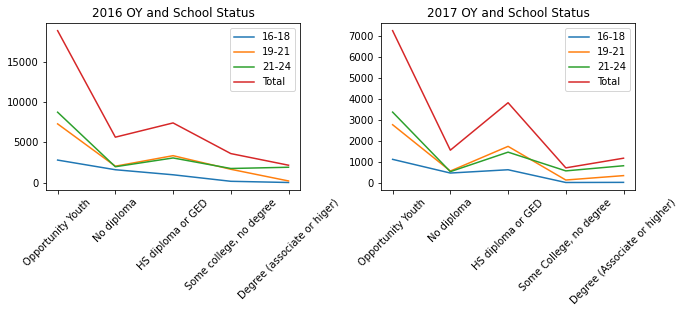

In [314]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
fig.tight_layout(pad=5)

ax[0].plot(old_oy.index, old_oy.values)
ax[0].set_title('2016 OY and School Status');

ax[1].plot(sch_oy_df.index, sch_oy_df.values)
ax[1].set_title('2017 OY and School Status');

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.legend(['16-18', '19-21', '21-24', 'Total'])


In [20]:
#Read in shape file for geo data
gdf = gpd.read_file("src/data/shapefiles/ipums_puma_2010.shp")

In [21]:
#Extract Washington, King County, and South King County
gdf["PUMA"] = gdf["PUMA"].astype(str).astype(int)
washington_map = gdf[(gdf['State']=='Washington')]
greater_king_co_map= gdf[(gdf.PUMA >= 11606) & (gdf.PUMA <= 11616)]
south_king_co_map=gdf[(gdf.PUMA >= 11612) & (gdf.PUMA <= 11615)]

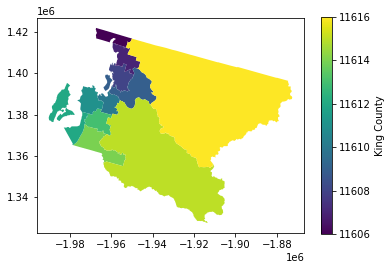

In [22]:
#Create a cloropeth of pumas in King County
fig, ax=plt.subplots()
greater_king_co_map.plot(column='PUMA',ax=ax, legend = True, legend_kwds={'label': "King County"})
plt.show()

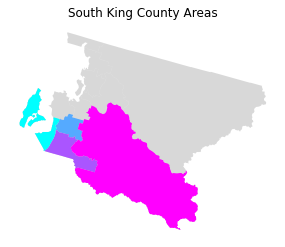

In [150]:
#Create a cloropeth of pumas in South King County
fig, ax=plt.subplots()
# washington_map.plot(ax=ax, color='grey',alpha = .1, zorder=1)
greater_king_co_map.plot(ax=ax, color='grey',alpha = .3, zorder=1);
south_king_co_map.plot(ax=ax, column = 'PUMA', cmap='cool', zorder= 2)
plt.title('South King County Areas')
plt.axis('off')
plt.show()
